# Design Process Figure

This notebook demonstrates the design process figure example, a simple demonstration of the design process using the flexible subset selection strategy. We can express criteria and approaches as objectives, blend them together, and tune the parameters to create subsets for visualization. This notebook generates Figure 1 of the paper in three parts figures/express.pdf, figures/blend.pdf, and figures/tune.pdf. The random dataset generated for the example and the subsets selected can be found in data/1-designProcess.

### Imports and Setup

In [1]:
# Third party libraries
import matplotlib.pyplot as plt
import matplotlib_inline

import numpy as np
import seaborn as sns 

# Local imports
import sets, loss, solver, plot

# Initialize notebook settings
sns.set_theme() # set seaborn theme
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots
%matplotlib inline 
%load_ext autoreload
%autoreload 2

## Express

Different criteria are expressed as objectives such as preserving the hull, highlighting outliers, or selecting distinctive points.

In [2]:
directory = "1-designProcess" # data directory for this notebook
verbose = False               # verbosity of solvers
seed = 123456789              # random generation seed for replicability


# Create a random blobs dataset to use as our example dataset
dataset = sets.Dataset(randTypes="blobs", size=(500, 2), seed=seed)
dataset.save(f"{directory}/full")

### Convex Hull Objective

In [3]:
# Precalculate the hull metric on the full dataset
dataset.preprocess(hull = loss.hullMetric)

# Create a unicriterion loss function with the hull metric and precomputation
lossFunction = loss.UniCriterion(objective = loss.preserveMetric, 
                                 metric = loss.hullMetric,
                                 datasetMetric = dataset.hull)

# Create a solve method with a greedy algorithm and a set subset size
solveMethod = solver.Solver(algorithm = solver.greedyMinSubset, 
                            loss = lossFunction)

# Solve for a convex hull subset
z, t, l = solveMethod.solve(dataset, epsilon=0, verbose=verbose, initialSize=3)
subsetHull = sets.Subset(dataset, z)
subsetHull.save(f"{directory}/hull")

### Outliers Objective

In [4]:
# Precalculate the outlierness (local outlier effect) of the full dataset
dataset.preprocess(outlierness = loss.outlierness)

# Create a loss function that is just the sum of the LOF in the subset
solveMethod.loss = loss.UniCriterion(objective=np.sum, solveArray="outlierness")
solveMethod.algorithm = solver.greedySwap

# Solve for an outlier subset
z, t, l = solveMethod.solve(dataset, subsetSize=40, verbose=verbose)
subsetOutliers = sets.Subset(dataset, z)
subsetOutliers.save(f"{directory}/outliers")

### Distinctiveness Subset

In [5]:
# Create a unicriterion loss function with the distinctiveness objective
dataset.preprocess(distances = loss.distanceMatrix)
solveMethod.loss = loss.UniCriterion(objective = loss.distinctiveness, 
                                     solveArray = "distances",
                                     selectBy = "matrix")

# Solve for distinctiveness subset
z, t, l = solveMethod.solve(dataset = dataset, 
                            subsetSize = 60, 
                            verbose = verbose)
subsetDistinct = sets.Subset(dataset, z)
subsetDistinct.save(f"{directory}/distinct")

### Plot

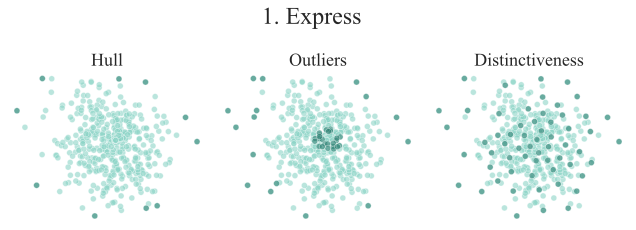

In [6]:
# Initialize color and plot settings
color = plot.Color()
plot.initialize(color)

titleSize = 24
subtitleSize = 18
titles = ["Hull", "Outliers", "Distinctiveness"]
subsets = [subsetHull, subsetOutliers, subsetDistinct]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
fig.text(0.49, 0.95, '1. Express', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    # ax.axis('off')  # Turn off axis for simplicity
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xlim([1, 5])
    # ax.set_ylim([1, 5])
    ax.set_title(titles[i], fontsize=subtitleSize)
    ax.set_aspect("equal")

    plot.scatter(ax = ax, 
                 color = color, 
                 dataset = dataset, 
                 subset = subsets[i], 
                 alpha = 0.6)
    

plt.savefig("figures/express.pdf", bbox_inches="tight")

## Blend

A simple example of how we can blend objectives at different levels by varying the weight parameters.

In [7]:
subsetSize = 80
objectives = [loss.earthMoversDistance, loss.distinctiveness]
parameters = [{"dataset": dataset.dataArray}, 
              {"solveArray": "distances", "selectBy": "matrix"}]
weights = np.array([1000, 0.1])
solveMethod.loss = loss.MultiCriterion(objectives, parameters, weights=weights)

z, t, l = solveMethod.solve(dataset, subsetSize=subsetSize, verbose=verbose)
subsetBlend1 = sets.Subset(dataset, z)
subsetBlend1.save(f"{directory}/blend1")

In [8]:
weights = np.array([10, 0.1])
solveMethod.loss = loss.MultiCriterion(objectives, parameters, weights=weights)

z, t, l = solveMethod.solve(dataset, subsetSize=subsetSize, verbose=verbose)
subsetBlend2 = sets.Subset(dataset, z)
subsetBlend2.save(f"{directory}/blend2")

In [9]:
weights = np.array([1, 1])
solveMethod.loss = loss.MultiCriterion(objectives, parameters, weights=weights)

z, t, l = solveMethod.solve(dataset, subsetSize=subsetSize, verbose=verbose)
subsetBlend3 = sets.Subset(dataset, z)
subsetBlend3.save(f"{directory}/blend3")

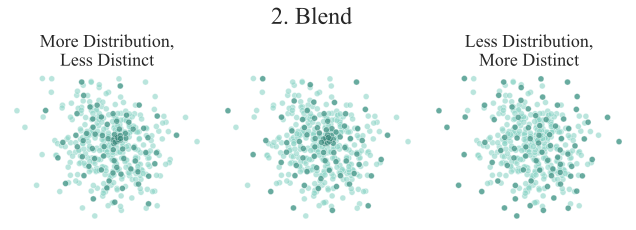

In [10]:
titles = ["More Distribution,\nLess Distinct", "", "Less Distribution,\nMore Distinct"]
subsets = [subsetBlend1, subsetBlend2, subsetBlend3]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
fig.text(0.49, 0.95, '2. Blend', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    # ax.axis('off')  # Turn off axis for simplicity
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xlim([1, 5])
    # ax.set_ylim([1, 5])
    ax.set_title(titles[i], fontsize=subtitleSize)
    ax.set_aspect("equal")

    plot.scatter(ax = ax, 
                 color = color, 
                 dataset = dataset, 
                 subset = subsets[i], 
                 alpha = 0.6)

plt.savefig("figures/blend.pdf", bbox_inches="tight")

## Tune

A basic example of the subset size parameter being tuned for different results

In [11]:
# Create a unicriterion loss function with the distinctiveness objective
solveMethod.loss = loss.UniCriterion(objective = loss.distinctiveness, 
                                     solveArray = "distances",
                                     selectBy = "matrix")
solveMethod.algorithm = solver.greedyMixed

# Solve for subsets with 3 different subset sizes
z, t, l = solveMethod.solve(dataset=dataset, weight=0.13, initialSize=3, verbose=verbose)
subsetDistinct1 = sets.Subset(dataset, z)
subsetDistinct1.save(f"{directory}/distinct1")

z, t, l = solveMethod.solve(dataset=dataset, weight=0.085, initialSize=3, verbose=verbose)
subsetDistinct2 = sets.Subset(dataset, z)
subsetDistinct2.save(f"{directory}/distinct2")

z, t, l = solveMethod.solve(dataset=dataset, weight=0.04, initialSize=3, verbose=verbose)
subsetDistinct3 = sets.Subset(dataset, z)
subsetDistinct3.save(f"{directory}/distinct3")

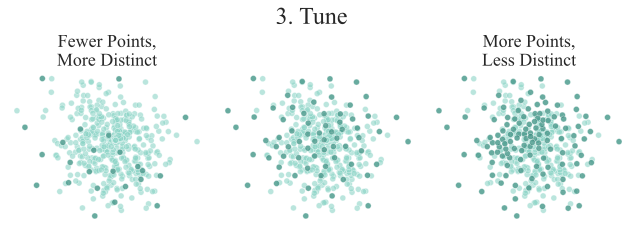

In [12]:
titles = ["Fewer Points,\nMore Distinct", "", "More Points,\nLess Distinct"]
subsets = [subsetDistinct1, subsetDistinct2, subsetDistinct3]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
fig.text(0.49, 0.95, '3. Tune', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    # ax.axis('off')  # Turn off axis for simplicity
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xlim([1, 5])
    # ax.set_ylim([1, 5])
    ax.set_title(titles[i], fontsize=subtitleSize)
    ax.set_aspect("equal")

    plot.scatter(ax = ax, 
                 color = color, 
                 dataset = dataset, 
                 subset = subsets[i], 
                 alpha = 0.6)

plt.savefig("figures/tune.pdf", bbox_inches="tight")